### Minimal Example

Most of the functionality of this package is bundled in two main classes: ESN
and ESNWrapper. (ESN stands for for Echo State Network.)
For all normal usage of the rescomp package, ESNWrapper is the
class to use.

As always, we first want to import the needed packages.

In [1]:
import rescomp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Then, we can create an instance of the ESNWrapper class to be used throughout 
this example.

In [2]:
esn = rescomp.ESNWrapper()

As with most machine learning techniques, we need some training data, which we
generate here artificially by simulating the chaotic Lorenz63 system for 5000
time steps.

In [3]:
simulation_time_steps = 5000

The starting point is chosen to be on the chaotic attractor we want to predict,
so that we don't use any transient dynamics as training data.  
Then we call the simulate_trajectory() function to simulate the Lorenz63 system.  
For more details on the simulation of systems, please see the 
simulations_example.

In [4]:
starting_point = np.array([-14.03020521, -20.88693127, 25.53545])
sim_data = rescomp.simulate_trajectory(
    sys_flag='lorenz', dt=2e-2, time_steps=simulation_time_steps,
    starting_point=starting_point)

As a convention, the data specified is always input data in an np.ndarray of
the shape (T, d), where T is the number of time steps and d the system
dimension
I.g. RC works for any number of dimensions and data length.

Until now, the object esn is basically empty. One main component of reservoir
computing is the reservoir, i.e. the internal network, wich we can create via
create_network().

For the sake of consistency, we want to set the random seed used to create the 
random network, so that we always create the same network, and hence the same
prediction, when running this example.

In [5]:
np.random.seed(0)

Now we can create the network.

In [6]:
esn.create_network()

A typical and natural way to use an ESN is to first synchronize on one section 
of a trajectory, train on the next and then start the prediction on the
subsequent data.  
The method train_and_predict() does exactly that.

The number of time steps used to synchronize the reservoir should be at least
a couple hundred but no more than a couple thousand are needed, even for
complex systems.

In [7]:
train_sync_steps = 400

The number of time steps used to train the reservoir: This depends hugely on
the system in question. See the FAQ for more details.

In [8]:
train_steps = 4000

The number of time steps to be predicted:

In [9]:
pred_steps = 500  

Plug it all in:

In [10]:
y_pred, y_test = esn.train_and_predict(
    x_data=sim_data, train_sync_steps=train_sync_steps, train_steps=train_steps, 
    pred_steps=pred_steps)

The first output y_pred is the the predicted trajectory
print(y_pred.shape)

If the input data is longer than the data used for synchronization and
training, i.e. if

> x_data.shape[0] > train_sync_steps + train_steps,

then the rest of the data can be used as test set to compare the prediction
against. If the prediction where perfect y_pred and y_test would be the same
Be careful though, if

> x_data.shape[0] - (train_sync_steps + train_steps) < pred_steps
  
then the test data set is shorter than the predicted one:

> y_test.shape[0] < y_pred.shape[0].
  

Plot prediction and simulation to compare them

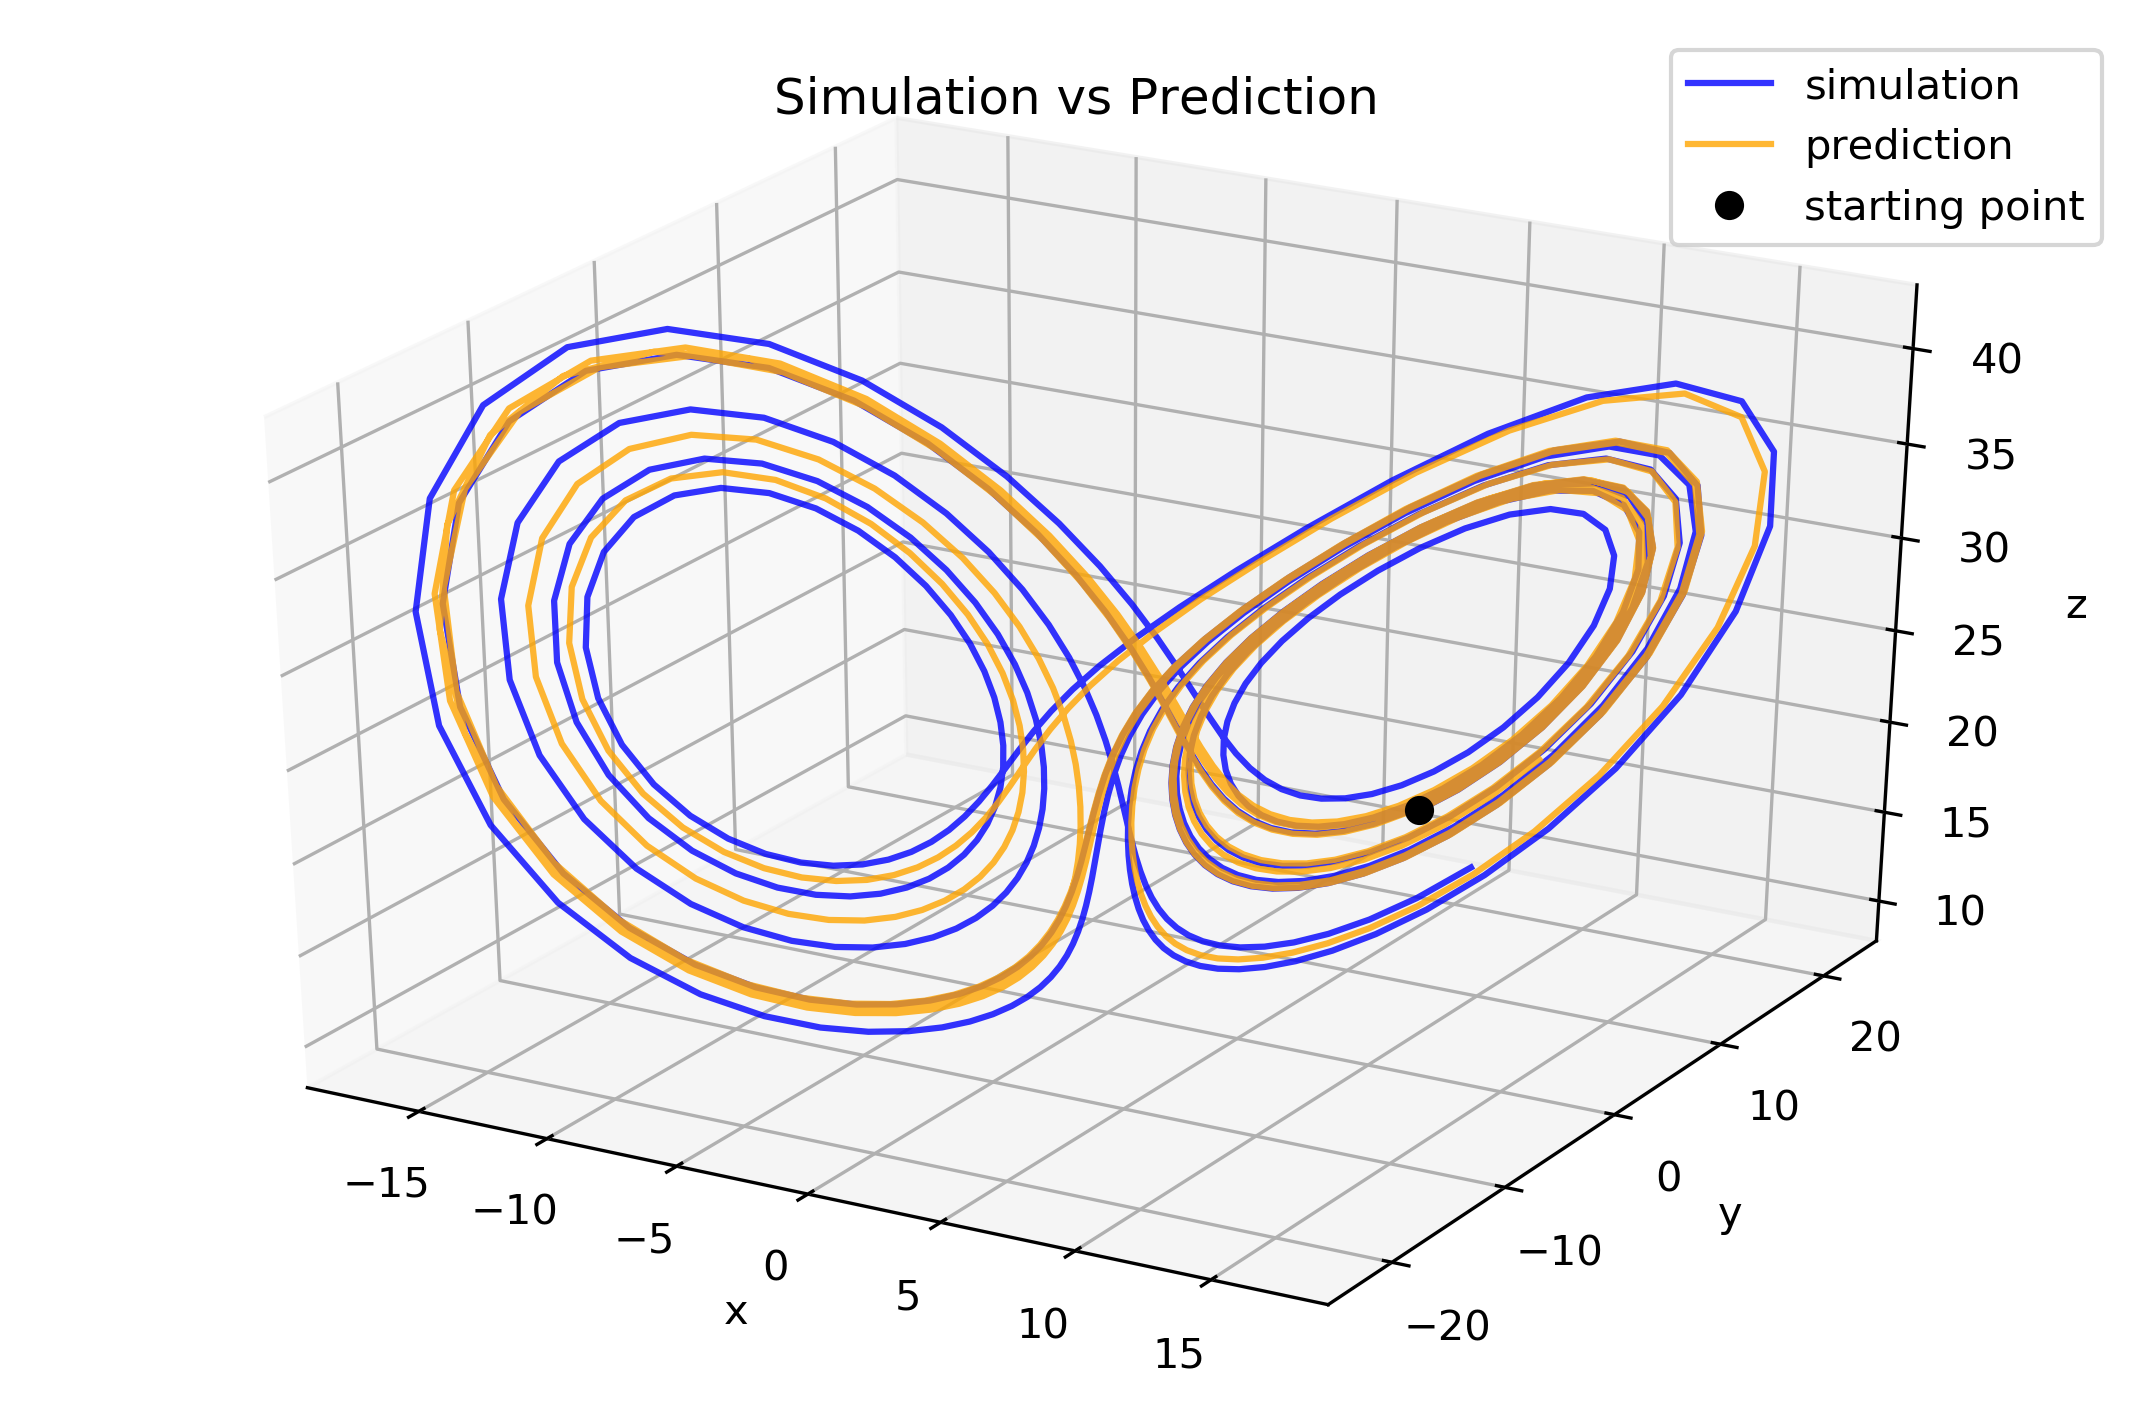

In [11]:
fig1 = plt.figure(figsize=(9, 6), dpi=300)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot(y_test[:, 0], y_test[:, 1], y_test[:, 2],
        alpha=0.8, color='blue', label='simulation')
ax1.plot(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2],
        alpha=0.8, color='orange', label='prediction')

start = y_pred[0]
ax1.plot([start[0]], [start[1]], [start[2]], 
         color='black', linestyle='', marker='o', label='starting point')

ax1.set_title("Simulation vs Prediction")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
plt.legend()
plt.show()

As you can see, both the prediction (orange) and the simulated data the 
prediction is based on (blue) show the same qualitative behavior of the Lorenz 
attractor.  
Qualitatively, the prediction of the Lorenz system was a success.

Now, plot their x coordinates as a more detailed comparison.

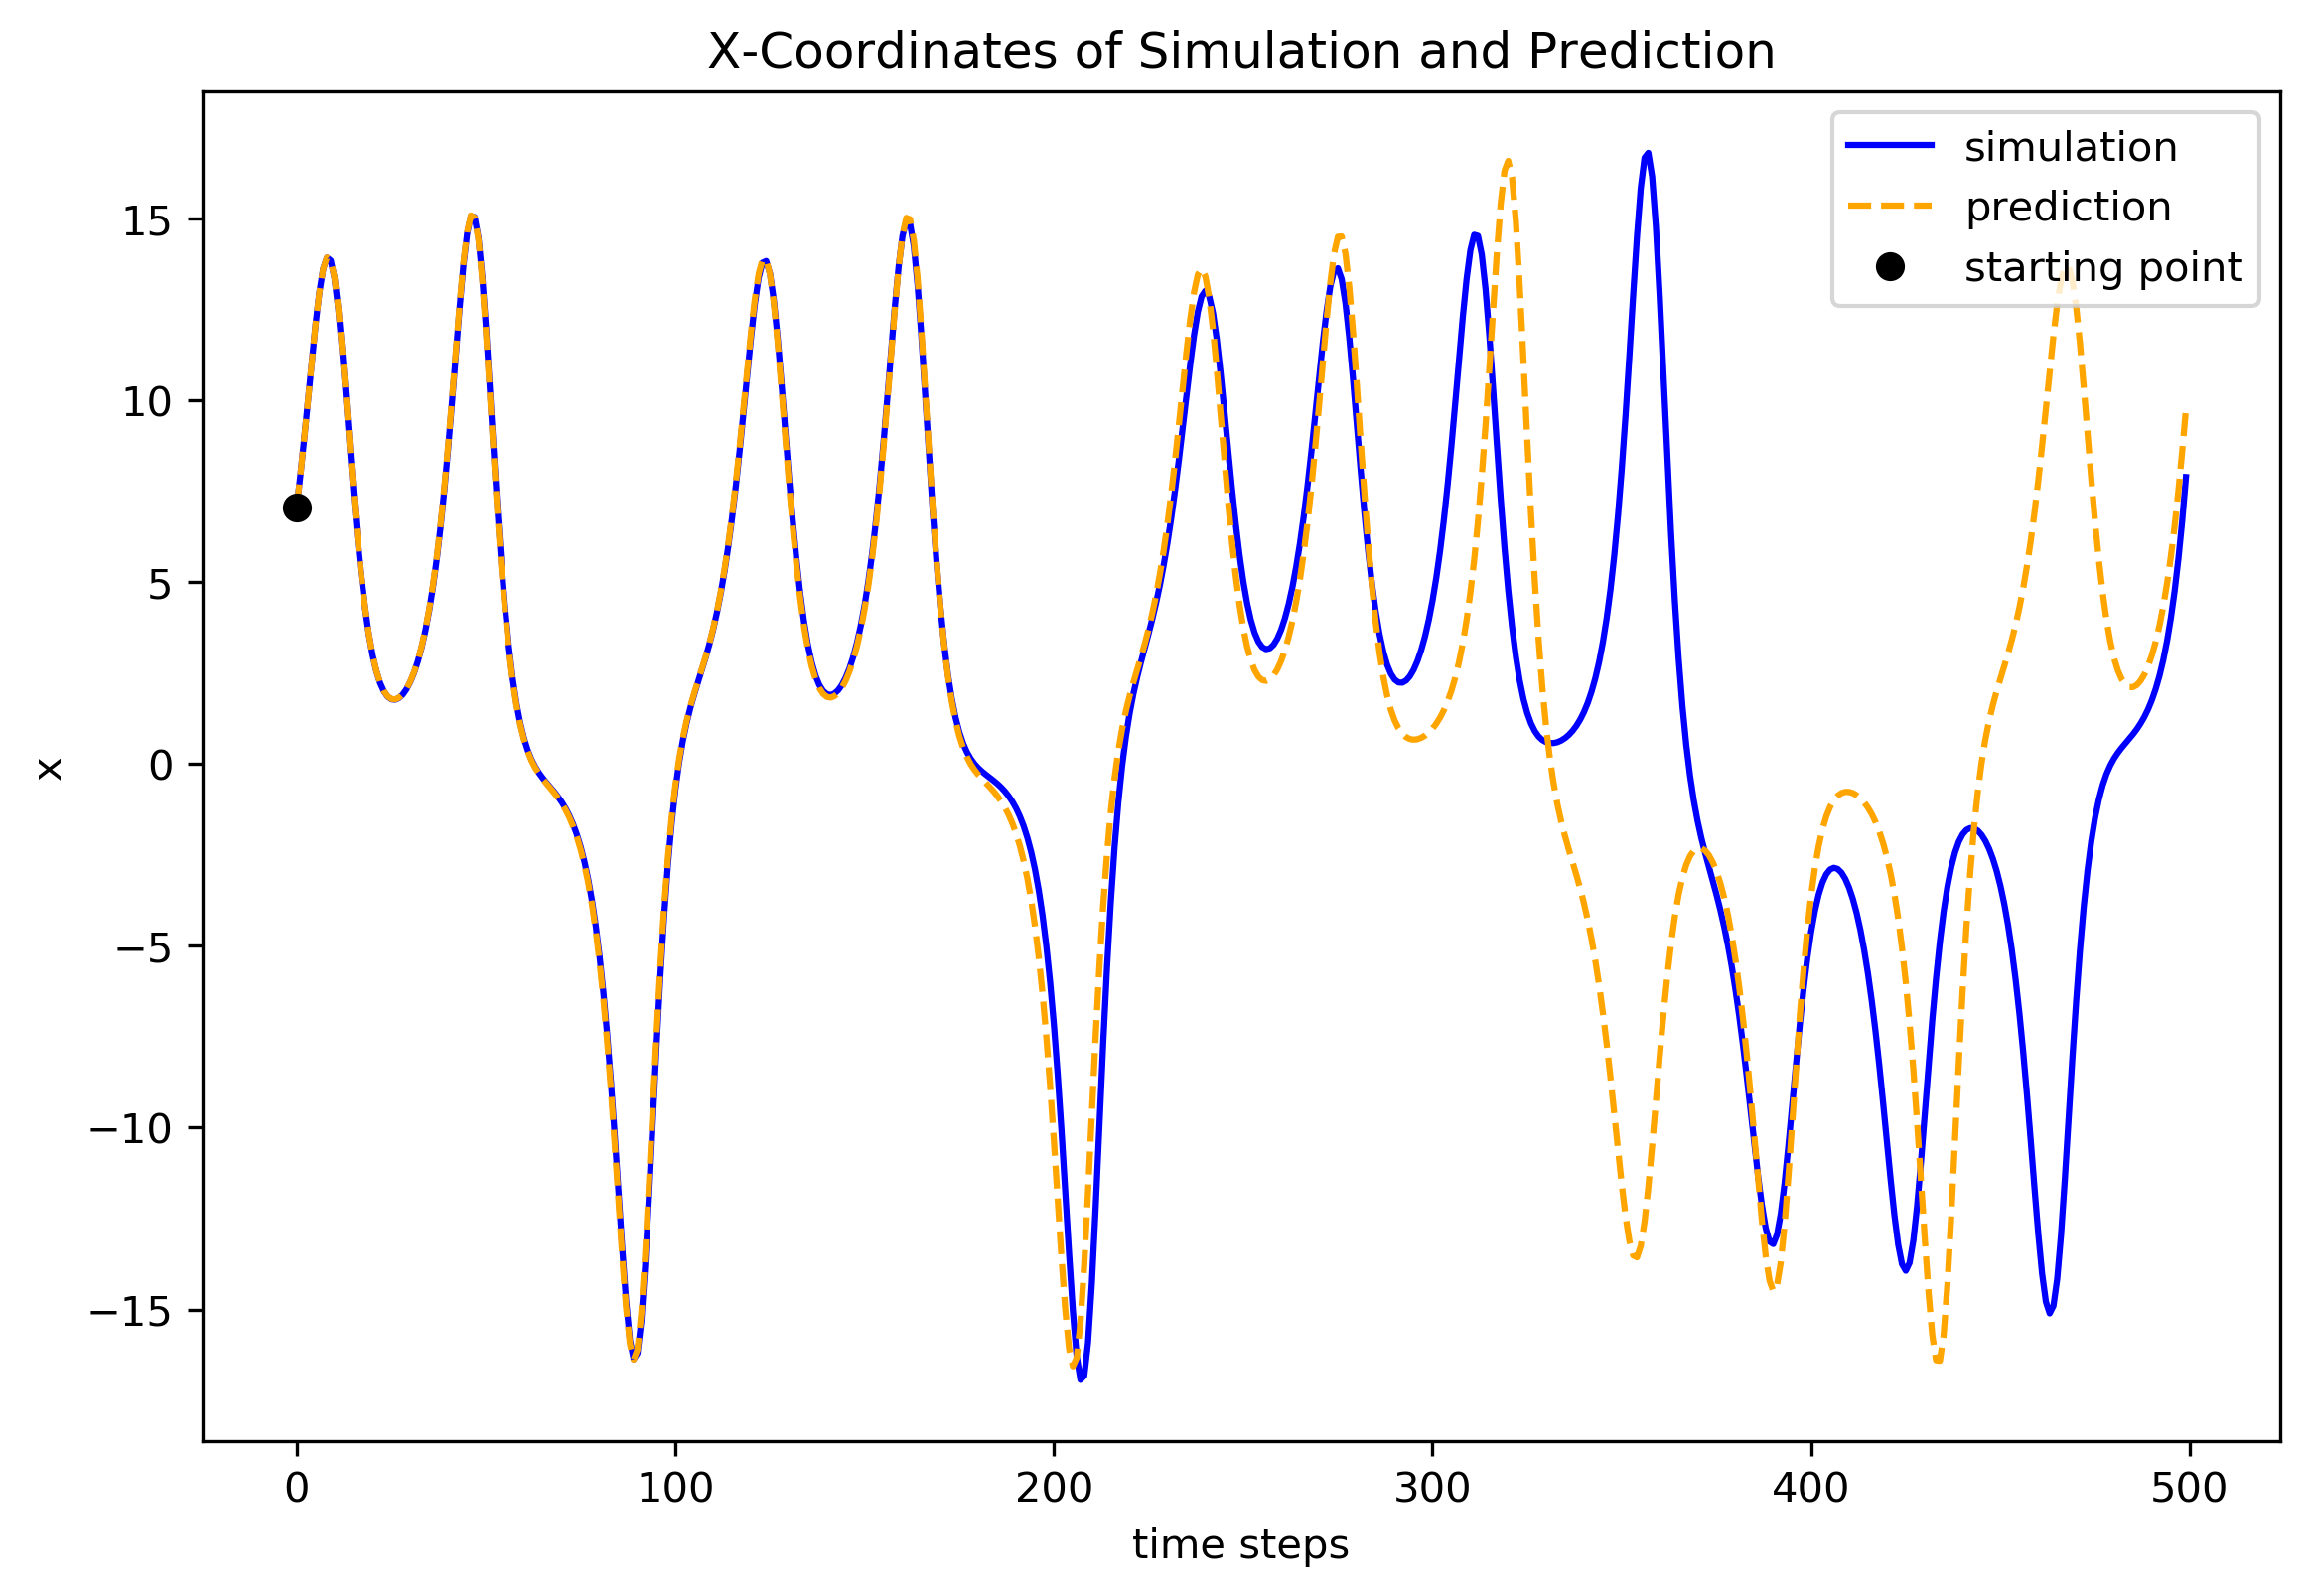

In [12]:
fig2 = plt.figure(figsize=(9, 6), dpi=300)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(y_test[:, 0], color='blue', label='simulation')
ax2.plot(y_pred[:, 0], color='orange', linestyle='--', label='prediction')

start = y_pred[0]
ax2.plot(start[0], color='black', linestyle='', marker='o', 
         label='starting point')

ax2.set_title("X-Coordinates of Simulation and Prediction")
ax2.set_xlabel('time steps')
ax2.set_ylabel('x')
plt.legend()
plt.show()

Looking at just the x-coordinate, it is clear that the prediction is basically 
identically with the simulation for the first ~175 time steps, after which the 
two start to diverge.  
From there on, they stay somewhat close until they diverge fully after about 
325 time steps.